### Import libraries

In [1]:
%matplotlib inline
# launch tensorboard to track model performance
%load_ext tensorboard
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
tf.__version__

'2.0.0'

In [2]:
MODEL_OUT_DIR = '/avacado_price_estimator'

In [3]:
## clear tensorboard logs
!rm -rf ./logs/
%tensorboard --logdir ./models/avacado_price_estimator/

### Load data and split into train and eval sets

In [4]:
data = pd.read_csv('./avocado.csv')
data.columns = ["Unnamed","Date" ,"AveragePrice","Total_Volume","4046","4225","4770","Total_Bags","Small_Bags","Large_Bags","XLarge_Bags","type","year","region"]

In [5]:
def get_random_split(data):
    msk = np.random.rand(len(data)) < 0.8
    return data[msk], data[~msk]
train_df, eval_df = get_random_split(data)

In [6]:
data.head()

,Unnamed,Date,AveragePrice,Total_Volume,4046,4225,4770,Total_Bags,Small_Bags,Large_Bags,XLarge_Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


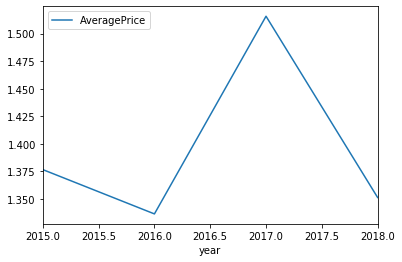

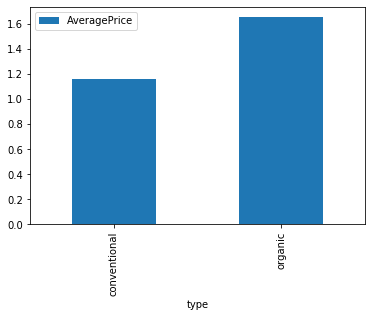

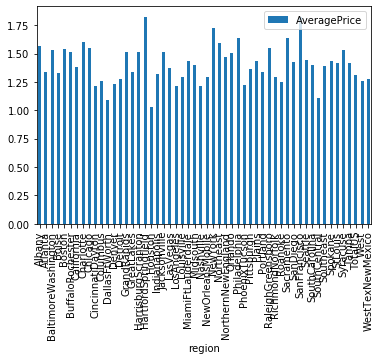

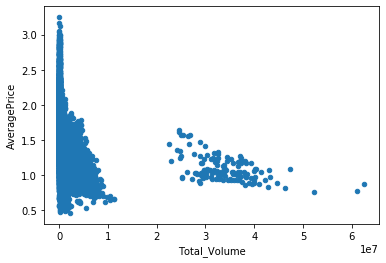

In [7]:
# average prices over the years
train_df.groupby('year').mean().plot(y='AveragePrice')
# average prices of different types
train_df.groupby('type').mean().plot(y='AveragePrice', kind='bar')
# average prices per region
train_df.groupby('region').mean().plot(y='AveragePrice', kind='bar')
# price vs volume sold
train_df.plot.scatter(x='Total_Volume', y='AveragePrice')
plt.show()

### Feature Creation

In [8]:
DENSE_COLUMNS = [
    'Total_Volume',
    '4046',
    '4225',
    '4770',
    'Total_Bags',
    'Small_Bags',
    'Large_Bags',
    'XLarge_Bags'
]

SPARSE_COLUMNS = ['type', 'year', 'region']

feature_columns = []
for feature in DENSE_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature))
for feature in SPARSE_COLUMNS:
    vocab = data[feature].unique()
    categorical_feature = tf.feature_column.categorical_column_with_vocabulary_list(feature, vocab)
    feature_columns.append(tf.feature_column.indicator_column(categorical_feature))

### Create dataset

In [9]:
def make_input_fn(df, epochs=500, shuffle=True, batch_size=32):
    df = df.copy()
    labels = df.pop('AveragePrice')
    def input_function():
        dataset = tf.data.Dataset.from_tensor_slices((dict(df), labels))
        
        if shuffle:
            dataset = dataset.shuffle(buffer_size=len(df))
        
        dataset = dataset.batch(batch_size).repeat(epochs)
        return dataset
    return input_function

train_input_fn = make_input_fn(train_df)
eval_input_fn = make_input_fn(eval_df, epochs=1, shuffle=False)

### Finally build an Estimator

###### Linear Regressor

In [10]:
linear_regressor = tf.estimator.LinearRegressor(
    feature_columns=feature_columns,
    model_dir='./models'+MODEL_OUT_DIR
)
linear_regressor.train(train_input_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': './models/avacado_price_estimator', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f948b3fc860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
If using Kera

In [13]:
linear_regressor.evaluate(eval_input_fn)

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-03-24T21:22:57Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./models/avacado_price_estimator/model.ckpt-227500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-03-24-21:22:57
INFO:tensorflow:Saving dict for global step 227500: average_loss = 0.29409438, global_step = 227500, la

{'average_loss': 0.29409438,
 'label/mean': 1.403408,
 'loss': 0.29465967,
 'prediction/mean': 1.2206013,
 'global_step': 227500}